In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [69]:
import astropy.units as u
from astropy.cosmology import z_at_value

In [70]:
from lenstools.simulations.fastpm import FastPMSnapshot 
from lenstools.simulations.raytracing import DensityPlane, PotentialPlane, RayTracer
from lenstools.image.convergence import ConvergenceMap
import bigfile

In [71]:
%%bash
ls /home/users/swmclau2/scratch/UatuFastpmTest/Box001/lightcone/1/*

/home/users/swmclau2/scratch/UatuFastpmTest/Box001/lightcone/1/attr-v2
/home/users/swmclau2/scratch/UatuFastpmTest/Box001/lightcone/1/header

/home/users/swmclau2/scratch/UatuFastpmTest/Box001/lightcone/1/Aemit:
000000
000001
000002
attr-v2
header

/home/users/swmclau2/scratch/UatuFastpmTest/Box001/lightcone/1/ID:
000000
000001
000002
attr-v2
header

/home/users/swmclau2/scratch/UatuFastpmTest/Box001/lightcone/1/Position:
000000
000001
000002
attr-v2
header

/home/users/swmclau2/scratch/UatuFastpmTest/Box001/lightcone/1/Velocity:
000000
000001
000002
attr-v2
header


In [72]:
class MyFastPMSnapshot(FastPMSnapshot):
    
    def getHeader(self):

        #Initialize header
        header = dict()
        bf_header = self.fp["."].attrs

        ###############################################
        #Translate fastPM header into lenstools header#
        ###############################################

        #Number of particles/files
        header["num_particles_file"] = bf_header["NC"][0]**3
        header["num_particles_total"] = header["num_particles_file"]
        header["num_files"] = 1

        #Cosmology
        header["Om0"] = bf_header["OmegaM"][0]
        header["Ode0"] = 1. - header["Om0"]
        header["w0"] = -1.
        header["wa"] = 0.
        header["h"] = bf_header['HubbleParam'][0]

        #Box size in kpc/h
        header["box_size"] = bf_header["BoxSize"][0]*1.0e3

        #Masses
        header["masses"] = bf_header['MassTable']*header["h"]

        #################

        return header
    def getPositions(self,first=None,last=None,save=True):

		#Get data pointer
		data = bigfile.BigData(self.fp)
		
		#Read in positions in Mpc/h
		if (first is None) or (last is None):
			positions = data["Position"][:]*self.Mpc_over_h
			#aemit = data["Aemit"][:]
		else:
			positions = data["Position"][first:last]*self.Mpc_over_h
			#aemit = data["Aemit"][first:last]

		#Enforce periodic boundary conditions
		for n in (0,1):
			positions[:,n][positions[:,n]<0] += self.header["box_size"]
			positions[:,n][positions[:,n]>self.header["box_size"]] -= self.header["box_size"]

		#Maybe save
		if save:
			self.positions = positions
			#self.aemit = aemit

		#Initialize useless attributes to None
		self.weights = None
		self.virial_radius = None
		self.concentration = None

		#Return
		return positions 

In [73]:
snap_path = "/home/users/swmclau2/scratch/UatuFastpmTest2/Box001/lightcone/1/"
snap = MyFastPMSnapshot.open(snap_path)
snap.getPositions()

<Quantity [[2.5006773e+01,7.5503442e+02,6.8747375e+02],
           [1.9142619e+02,1.3383902e+02,6.8747369e+02],
           [2.1295367e+02,2.9323776e+02,6.8747375e+02],
           ...,
           [5.4340918e+02,8.7766022e+02,3.5349400e-05],
           [5.4412286e+02,8.8889856e+02,2.0299965e-05],
           [8.7612695e+02,2.5344559e+02,7.1176378e-06]] Mpc/h>

In [74]:
snap.positions.value.shape

(90223670, 3)

In [75]:
 np.max(snap.positions, 0)

<Quantity [1024.    ,1024.    , 687.4738] Mpc/h>

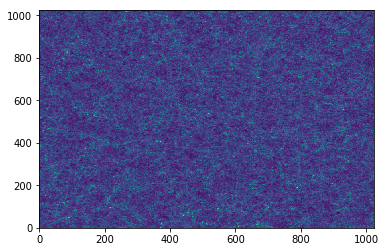

In [76]:
N = int(1e9)
plt.hist2d(snap.positions[:N,0], snap.positions[:N,1], bins = 500);

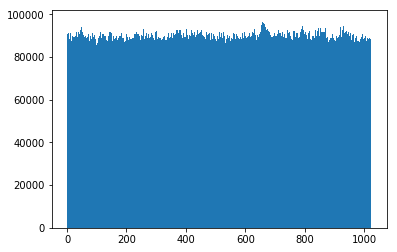

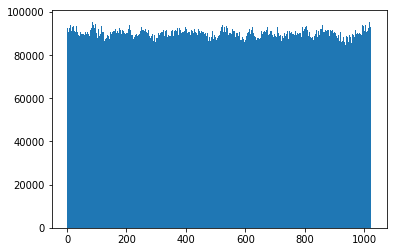

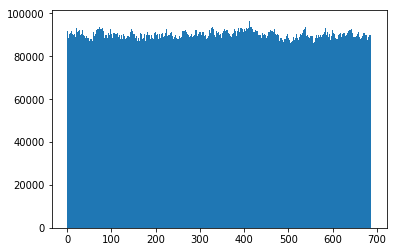

In [77]:
for i in xrange(3):
    plt.hist(snap.positions[:,i].value, bins = 1000);
    plt.show()

---

---

In [78]:
#Integrate up to this redshift
# TODO compare to the boxes used in another paper before running anything. 
z = 0.2
chi_max = snap.cosmology.comoving_distance(z)
chi_max

<Quantity 799.54989518 Mpc>

In [79]:
#Lens discretization
num_lenses = 25

thickness = chi_max / num_lenses
chi_start = thickness/2
chi_end = chi_max - thickness/2

#Lens centers
chi_centers = np.linspace(chi_start.value,chi_end.value,num_lenses)*chi_max.unit

chi_centers

<Quantity [ 15.9909979 , 47.97299371, 79.95498952,111.93698532,
           143.91898113,175.90097694,207.88297275,239.86496855,
           271.84696436,303.82896017,335.81095597,367.79295178,
           399.77494759,431.7569434 ,463.7389392 ,495.72093501,
           527.70293082,559.68492662,591.66692243,623.64891824,
           655.63091404,687.61290985,719.59490566,751.57690147,
           783.55889727] Mpc>

In [80]:
thickness

<Quantity 31.98199581 Mpc>

In [81]:
#Cut the lenses and add them to the raytracer
res = 4096*2#*36
smooth = 1
print res, smooth
print
tracer = RayTracer()
for i,chi in enumerate(chi_centers):
    print i,
    zlens = z_at_value(snap.cosmology.comoving_distance,chi)
    d,r,n = snap.cutPlaneGaussianGrid(normal=2,center=chi,thickness=thickness,plane_resolution=res,kind="potential", smooth=smooth)
    #print n
    #plt.imshow(d.value)
    #plt.show();
    lens = PotentialPlane(d.value,angle=snap.header["box_size"],comoving_distance=chi,redshift=zlens,cosmology=snap.cosmology,unit=u.rad**2)
    tracer.addLens(lens)

#Add a fudge lens at the end (needed by ODE solver implementation)
chi_fudge = chi_end + thickness
z_fudge = 1000.
tracer.addLens(PotentialPlane(np.zeros((res,res)),angle=snap.header["box_size"],redshift=z_fudge,comoving_distance=chi_fudge,cosmology=snap.cosmology,num_particles=None))

#Order lenses
tracer.reorderLenses()

8192 1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24


In [82]:
#Field of view
fov = 360*u.deg
fov_resolution = 256
delta = 0
#Initial ray positions
b = np.linspace(0.+delta,fov.value+delta,fov_resolution)
pos = np.array(np.meshgrid(b,b))*fov.unit

/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


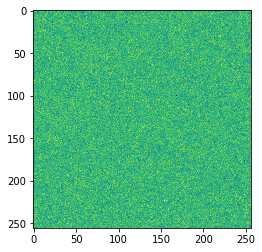

In [83]:
conv_born = tracer.convergenceBorn(pos,z=z, save_intermediate=False)
conv_born = ConvergenceMap(conv_born,angle=fov)
plt.imshow(np.log10(conv_born.data -conv_born.data.min()))

In [84]:
#Field of view
fov = 10*u.deg
fov_resolution = 256
delta = 0
#Initial ray positions
b = np.linspace(0.+delta,fov.value+delta,fov_resolution)
pos = np.array(np.meshgrid(b,b))*fov.unit

/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


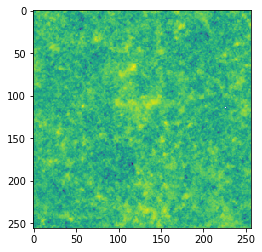

In [85]:
conv_born = tracer.convergenceBorn(pos,z=z, save_intermediate=False)
conv_born = ConvergenceMap(conv_born,angle=fov)
plt.imshow(np.log10(conv_born.data -conv_born.data.min()))

In [86]:
from scipy.ndimage import gaussian_filter

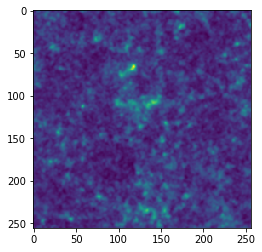

In [87]:
smoothed_conv_born  = gaussian_filter(conv_born.data, 1)
plt.imshow(smoothed_conv_born)